<a href="https://colab.research.google.com/github/Andribi/A2MF_AP/blob/main/A2MF_AP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2MF_AP

Multimodal face synthesis based on Att2MFace https://arxiv.org/abs/2104.04362 

## Structure preparation

In [1]:
#GPU

%tensorflow_version 2.x
import tensorflow as tf
!pip show tensorflow
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Name: tensorflow
Version: 2.7.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: tensorflow-io-gcs-filesystem, numpy, keras-preprocessing, typing-extensions, tensorflow-estimator, absl-py, gast, wheel, google-pasta, opt-einsum, libclang, tensorboard, flatbuffers, termcolor, keras, astunparse, h5py, grpcio, protobuf, six, wrapt
Required-by: kapre
Found GPU at: /device:GPU:0


In [2]:
# IMPORTS 

from keras.layers import Conv2D, Input, Dense, UpSampling2D, AveragePooling2D, Reshape, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import cv2 as cv
import keras
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# GLOBAL VARIABLES

# dataset path
DS_PATH = '/content/A2MF_AP/fairface'

# train labels path
TRAIN_LABELS_PATH = "fairface_label_train.csv"

# validation labels path
VAL_LABELS_PATH = "fairface_label_val.csv"

# size of noise vector
LATENT_DIM_GAN = 512 

# dimension of images
SPATIAL_DIM = 256

# size of attributes
ATT_SIZE = 17

# number of c modalities
C = 2

# real dimention of images
REAL_DIM = 224 

# number of epochs 
EPOCHS = 50

# number of img for batch
BATCH_SIZE = 16

# seed for shuffle
SEED = 123

## Data analysis

In [4]:
# FAIRFACE CLONE

import os

!git clone https://github.com/Andribi/A2MF_AP.git
%cd A2MF_AP/fairface/ 

Cloning into 'A2MF_AP'...
remote: Enumerating objects: 195130, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 195130 (delta 2), reused 0 (delta 0), pack-reused 195124
Receiving objects: 100% (195130/195130), 1.80 GiB | 37.04 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (195403/195403), done.
/content/A2MF_AP/fairface


In [5]:
# DATA LOAD

fairface_train = pd.read_csv(TRAIN_LABELS_PATH)
fairface_val = pd.read_csv(VAL_LABELS_PATH)
fairface = pd.concat([fairface_train, fairface_val])

fairface.head(5)

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


Total number of images in Fairface: 97698
Total number of images in Fairface Train: 86744
Total number of images in Fairface Validation: 10954


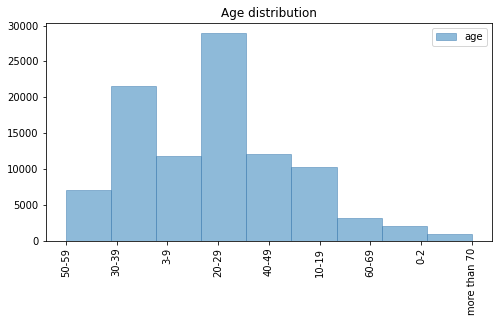

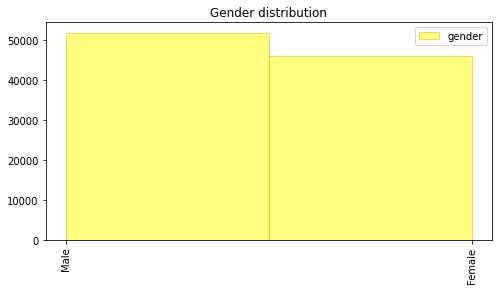

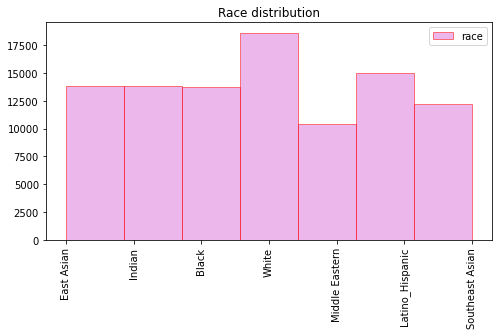

In [6]:
# DISTRIBUTIONS

print('Total number of images in Fairface: ' + str(fairface.shape[0]))
print('Total number of images in Fairface Train: ' + str(fairface_train.shape[0]))
print('Total number of images in Fairface Validation: ' + str(fairface_val.shape[0]))

age = fairface["age"]
age_bins=len(age.value_counts())

gender = fairface["gender"]
gender_bins=len(gender.value_counts())

race = fairface["race"]
race_bins=len(race.value_counts())

age.hist(bins=age_bins, figsize=[8,4], xrot=90, edgecolor='steelblue', linewidth=1, grid=False, alpha=0.5, legend=True)
plt.title('Age distribution')
plt.show()

gender.hist(bins=gender_bins, figsize=[8,4], xrot=90, edgecolor='orange', linewidth=1, grid=False, alpha=0.5, legend=True, color='yellow')
plt.title('Gender distribution')
plt.show()

race.hist(bins=race_bins, figsize=[8,4], xrot=90, edgecolor='red', linewidth=1, grid=False, alpha=0.5, legend=True, color='orchid')
plt.title('Race distribution')
plt.show()

In [7]:
# MISSING VALUES

print('Percentage of missing values:', round((fairface.isna().sum().sum() / fairface.shape[0]) * 100 , 2), '%')

Percentage of missing values: 0.0 %


In [8]:
# ENCODING

enc_fairface = fairface.drop(columns='service_test')
enc_fairface_train = fairface_train.drop(columns='service_test')
enc_fairface_val = fairface_val.drop(columns='service_test')

def encode_dataset(df):
  """
  Function to encode dataframe using One Hot encoding

  Parameters
  ----------
  df (DataFrame) :  A dataframe with names and attributes of a specific dataset 
                    of images

  Returns
  -------
  df (DataFrame) :  Encoded DataFrame
  """

  attr = df.drop(columns='file')
  names = pd.DataFrame(df['file'])  
  
  enc_df = pd.get_dummies(attr, dtype=int)
  enc_df = enc_df.drop(columns='gender_Female')
  df = pd.concat([names, enc_df], axis=1)
  
  print(df.shape)
  return df

def _sk(x):
  """ 
  Function to transform a path for visual images in a path for sketch images

  Parameters
  ----------
  x (str) :  Path in input (example: 'val/1.jpg' or 'train/1.jpg')

  Returns
  -------
  x (str) :  Transformd path (example: 'val_sk/1.jpg' or 'train_sk/1.jpg')
  """

  if 'train' in x:
    x = x[:5] + '_sk' + x[5:]
  if 'val' in x:
    x = x[:3] + '_sk' + x[3:]
  return x 

# full fairface visible
ff_df = encode_dataset(enc_fairface).replace(0, -1)

# train set visible
train_df = encode_dataset(enc_fairface_train).replace(0, -1)

# val set visible
val_df = encode_dataset(enc_fairface_val).replace(0, -1)

# train set sketch
train_sk_df = train_df.copy()
train_sk_df['file'] = train_sk_df['file'].apply(_sk)

# val set sketch
val_sk_df = val_df.copy()
val_sk_df['file'] = val_sk_df['file'].apply(_sk)

# train set visible + sketch
mixed_train = pd.concat([train_df, train_sk_df], axis=0)
mixed_train = mixed_train.sample(frac=1, random_state=SEED).reset_index(drop=True)
print(mixed_train.shape)

# val set visible + sketch
mixed_val = pd.concat([val_df, val_sk_df], axis=0)
mixed_val = mixed_val.sample(frac=1, random_state=SEED).reset_index(drop=True) 
print(mixed_val.shape)

mixed_train.head(15)

(97698, 18)
(86744, 18)
(10954, 18)
(173488, 18)
(21908, 18)


,file,age_0-2,age_10-19,age_20-29,age_3-9,age_30-39,age_40-49,age_50-59,age_60-69,age_more than 70,gender_Male,race_Black,race_East Asian,race_Indian,race_Latino_Hispanic,race_Middle Eastern,race_Southeast Asian,race_White
0,train_sk/70802.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1
1,train_sk/28619.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1
2,train/22065.jpg,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1
3,train_sk/84261.jpg,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
4,train/34487.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,1
5,train/81176.jpg,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1
6,train/22980.jpg,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1
7,train/25960.jpg,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1
8,train/40616.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1
9,train_sk/79373.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1


## Dataset

In [9]:
# DATASET CREATION USING TENSORFLOW

def parse_function(filename, label):
  """ 
  Function to open, decode in jpeg, convert in float and resize an image 

  Parameters
  ----------
  filename :  Name of the image 
  label    :  Attributs relative to the image

  Returns
  -------
  image (EagerTensor)    :  Opened and parsed image 
  label (EagerTensor)    :  Attributes relative to the image
  filename (EagerTensor) :  Name of the image
  """

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [SPATIAL_DIM, SPATIAL_DIM])
  return image, label, filename

def create_ds(df):
  """
  Function to create a Tensorflow BatchDataset from a Pandas dataframe. 
  There are three elements in the dataset: images, labels and filenames. 
  The dataset is divided in batches of BATCH_SIZE elements and is shuffled based
  on SEED. 

  Parameters
  ----------
  df (DataFrame) :  A dataframe with names and attributes of a specific dataset 
                    of images

  Returns
  -------
  dataset (BatchDataset) :  Tensorflow Batch Dataset
  """

  filenames = df['file'].values
  labels = df.drop(columns='file').values
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(parse_function)
  dataset = dataset.batch(BATCH_SIZE)
  return dataset

train_ds = create_ds(train_df)
val_ds = create_ds(val_df)
train_sk_ds = create_ds(train_sk_df)
val_sk_ds = create_ds(val_sk_df)
mixed_train_ds = create_ds(mixed_train)
mixed_val_ds = create_ds(mixed_val)

print('Train batches ------------->', len(train_ds))
print('Train Sketch batches ------>', len(train_sk_ds))
print('Validation batches -------->', len(val_ds))
print('Validation Sketch batches ->', len(val_sk_ds))
print('Mixed train batches ------->', len(mixed_train_ds))
print('Mixed validation batches -->', len(mixed_val_ds))

Train batches -------------> 5422
Train Sketch batches ------> 5422
Validation batches --------> 685
Validation Sketch batches -> 685
Mixed train batches -------> 10843
Mixed validation batches --> 1370


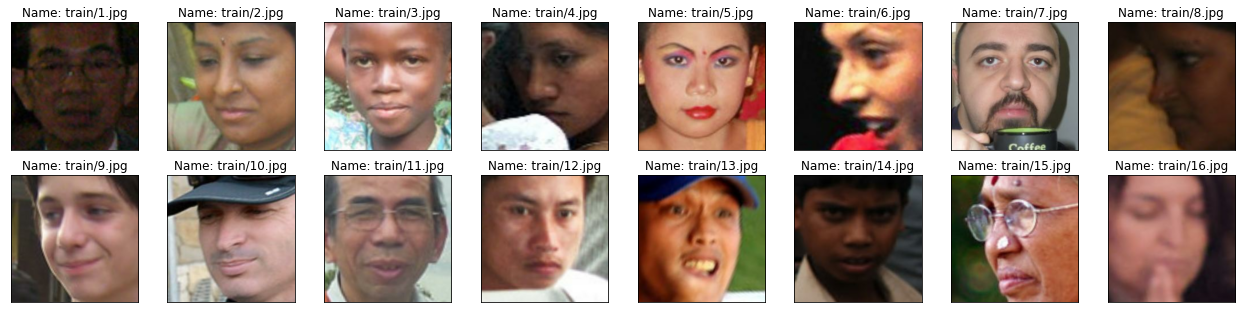

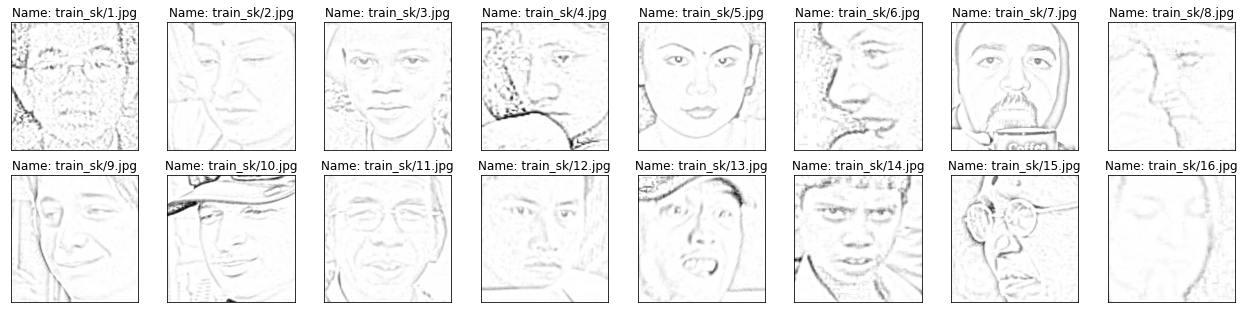

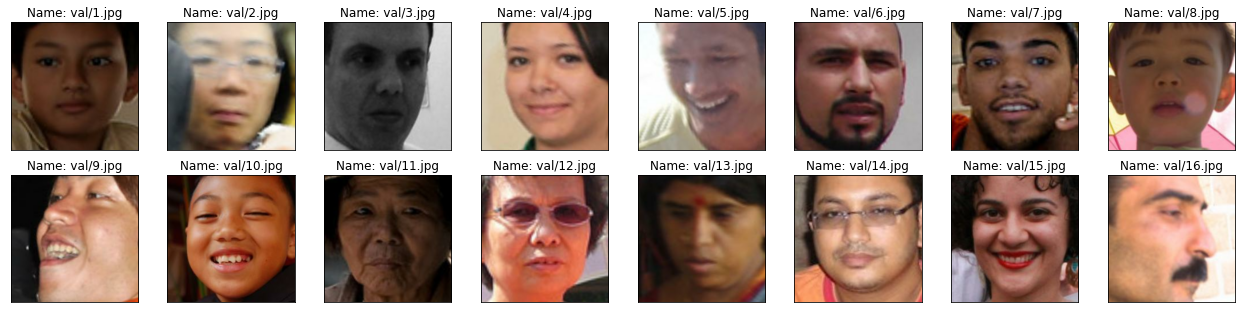

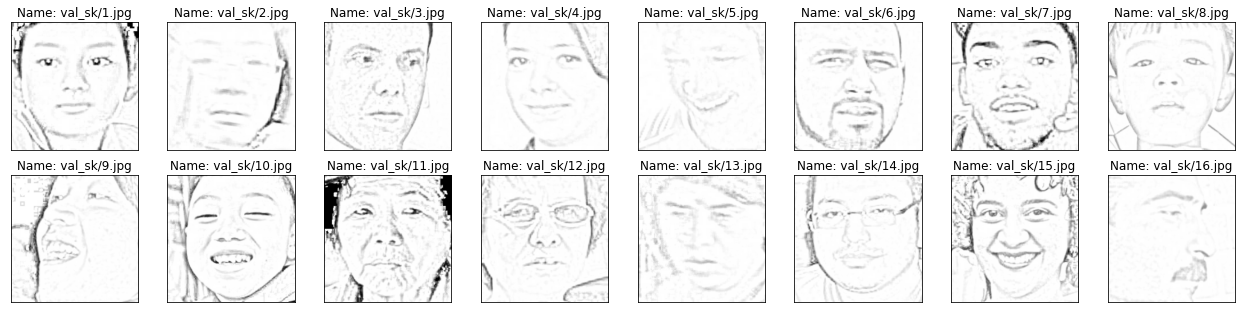

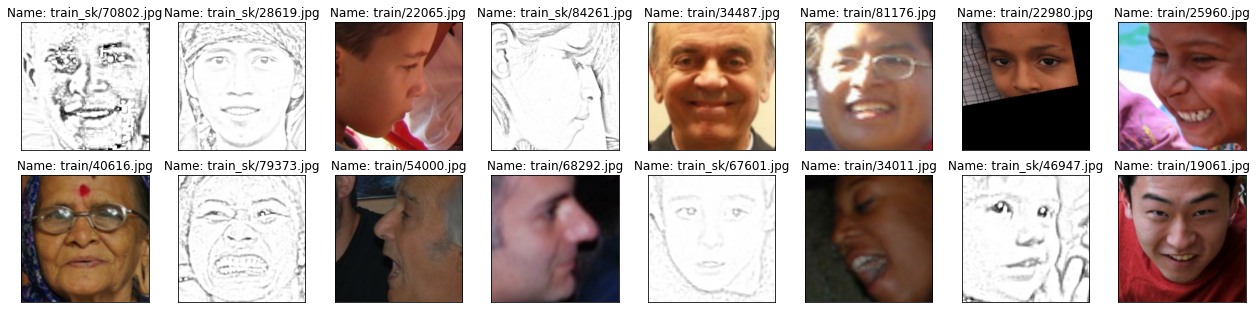

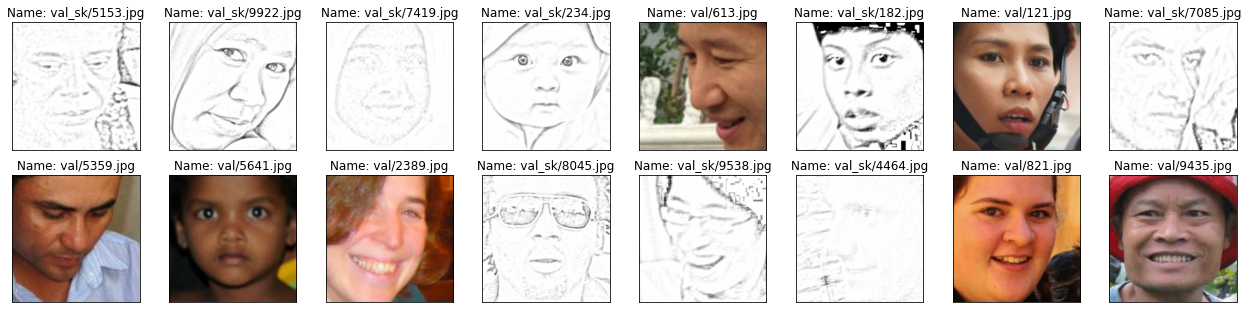

In [10]:
# IMAGE IN DATASET VISUALIZATION

def view_image(ds):
  """
  Visualize images of a Batch Dataset

  Parameters
  ----------
  ds (BatchDataset) :  A batch dataset of images containing image, label, name
  """

  image, label, name = next(iter(ds)) 
  image = image.numpy()
  label = label.numpy()
  name = name.numpy()
  fig = plt.figure(figsize=(22, 22))
  for i in range(16):
      ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
      ax.imshow(image[i])
      ax.set_title(f"Name: {str(name[i],'utf-8')}")

view_image(train_ds)
view_image(train_sk_ds)
view_image(val_ds)
view_image(val_sk_ds)
view_image(mixed_train_ds)
view_image(mixed_val_ds)

## Image Synthesis : Generator and Discriminator

In [11]:
# PIXEL WISE LAYER 

class PixelWise(tf.keras.layers.Layer):
  """
  Pixel-wise feature equalization
  F = F̃/sqrt(1/N * sum(form 1 to N, (F̃^i)^2) + ε)

  Parameters
  ----------
  x (Tensor)    : feature vector
  epsilon (int) : ε parameter, default 10^-8

  Returns
  -------
  Normalized keras layer 
  """
  def __init__(self, epsilon=1e-8, name='Pixel-Wise'):
    super(PixelWise, self).__init__()
    self.epsilon = epsilon
    self._name = name

  def call(self, inputs):
    x = inputs
    return x * tf.math.rsqrt(tf.reduce_mean(tf.square(x), axis=1, keepdims=True) + self.epsilon)


In [12]:
# GENERATOR

def build_generator(latent_dim, autentication_vector, modalities):
  """
  Function to create che generator network for the GAN. This generator consists 
  on creating face images in different modalities. 

  Parameters
  ----------
  latent_dim (int)           : dimention of noise vector z
  autentication_vector (int) : number of attributes of an image
  modalities (int)           : number of supported modalities 

  Returns
  -------
  The generator model
  """

  def add_multi_stretchout(output, x, name_number, c, linear=True): 
    """
    Adds a multimodal stretch-out module to the network. It is realized adding a 
    1x1 convolutional 2D layer with linear activation function if required

    Parameters
    ----------
    output (int)         : output shape
    x (Tensor)           : input layer
    name_number (String) : block number relative to the name of the layer 
    linear (bool)        : activation function, default True

    Returns
    -------
    x (Tensor) :  multimodal stretch-out layer
    """
    if linear:
        x = Conv2D(output, 
                   kernel_size=1, 
                   activation='linear', 
                   padding='same', 
                   name='Multi_stretchout_' + name_number + '_' + c)(x)
    else:
        x = Conv2D(output, 
                   kernel_size=1, 
                   padding='same', 
                   name='Multi_stretchout_' + name_number + '_' + c)(x)
    return x

  def add_transition_block(output, x, name_number):
    """
    Adds a transition block module to the nwtwork. It includes an upsampling 
    layer followed by two 3x3 convolutional layers normailized by pixel-wise 
    equalization and with LeakyReLU function (using alpha = 0.2)

    Parameters
    ----------
    output (tuple)       : output shape
    x (Tensor)           : input layer
    name_number (String) : block number relative to the name of the layer  

    Returns
    -------
    x (Tensor): the transition module
    """
    x = UpSampling2D(interpolation="nearest", 
                     name='Transition_block_' + name_number + '_Upsampling')(x)
    x = Conv2D(output, 
               kernel_size=3, 
               padding='same', 
               name='Transition_block_' + name_number + '_Conv1')(x)
    x = PixelWise(name='Pixel-Wise_'+ name_number + '_1')(x)
    x = LeakyReLU(alpha=0.2, 
                  name='Transition_block_' + name_number + '_LReLU1')(x)
    x = Conv2D(output, 
               kernel_size=3, 
               padding='same', 
               name='Transition_block_' + name_number + '_Conv2')(x)
    x = PixelWise(name='Pixel-Wise_'+ name_number + '_2')(x)
    x = LeakyReLU(alpha=0.2, 
                  name='Transition_block_' + name_number + '_LReLU2')(x)
    return x

  # input is a noise vector concatenated with an autentication_vector
  inp = Input(shape=(latent_dim + autentication_vector), name='Input')

  # MLP BLOCK
  x = Dense(4 * 4 * 512, 
            input_dim=latent_dim + autentication_vector, 
            name='MLP_fully_connected')(inp) 
  x = LeakyReLU(alpha=0.2, 
                name='MLP_LReLU')(x)
  x = Reshape(target_shape=(4, 4, 512), 
              name='MLP_reshape')(x)

  # INITIAL BLOCK 
  x = Conv2D(512, 
             kernel_size=3, 
             padding='same', 
             name='Initial_block_Conv')(x)
  x = PixelWise(name='Initial_block_PixelWise_1')(x)
  x = LeakyReLU(alpha=0.2, 
                name='Initial_block_LReLU')(x)

  for i in range(6): 
    if i == 0: 
      x = add_transition_block(512, x, str(i+1))
    else: 
      x = add_transition_block(512/2**i, x, str(i+1))

  '''
  # BLOCKS
  for i in range(6): 
    if i == 0: 
      x = add_block_G(str(i+1), x, 3, False, 512)
    else:
      x = add_block_G(str(i+1), x, 3, True, 512/2**i)
  
  # MULTIMODAL STRETCH-OUT 7
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '7', str(c + 1))'''

  # MULTIMODAL STRETCH-OUT 7 EMBEDDING
  output = []
  for j in range(C):
    output.append(add_multi_stretchout(3, x, '7', str(j+1)))

  return Model(inputs=inp, outputs=output, name='Generator_model')

Model: "Generator_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 529)]        0           []                               
                                                                                                  
 MLP_fully_connected (Dense)    (None, 8192)         4341760     ['Input[0][0]']                  
                                                                                                  
 MLP_LReLU (LeakyReLU)          (None, 8192)         0           ['MLP_fully_connected[0][0]']    
                                                                                                  
 MLP_reshape (Reshape)          (None, 4, 4, 512)    0           ['MLP_LReLU[0][0]']              
                                                                                    

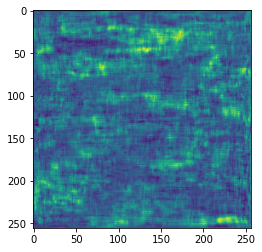

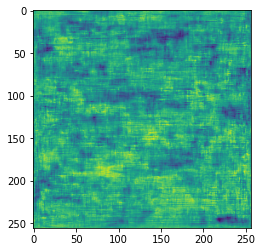

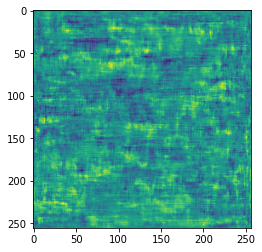

In [20]:
# prova gen 

#noise = tf.random.uniform(shape=[1, 512], minval=-1.0, maxval=1.0)

noise = np.random.uniform(-1.0, 1.0, size=512)
attr = np.array([-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0])
mod = 2

generator = build_generator(512, len(attr), 2)
generator.summary()

x = np.concatenate((noise, attr), axis=0)
#x = tf.convert_to_tensor(x)
y = np.expand_dims(x, axis=0)
print(y.shape)
#out1, out2 = generator.predict(y)
out1, out2 = generator(y)
print(out1.shape)
imgplot = plt.imshow(out1[0, :, :, 0])
plt.show()
imgplot2 = plt.imshow(out2[0, :, :, 0])
plt.show()
out = out1 + out2 
imgplot2 = plt.imshow(out[0, :, :, 0])
plt.show()


In [15]:
# DISCRIMINATOR

def build_discriminator(spatial_dim, modalities, attribute_size):
  """
    Function to create discriminator that evaluates the input images of 
    different modalities, applying a stretch-in module that makes them modality
    invariant images. The discriminator has two outputs:
      - DC : Estimator, it aims to learn the mapping from the input image to the
             corresponding target label probability distribution
      - DA : Authenticator, it measures the probability of whether a given 
             multimodal sample belongs to the data distribution

    Parameters
    ----------
    spatial_dim (int)    : shape of input images 
    modalities (int)     : number of supported modalities  
    attribute_size (int) : number of attributes 

    Returns
    -------
    The discriminator model
    """

  def add_multi_stretchin(output, x, name_number, c, linear=True): 
    """
    Adds a multimodal stretch-in module to the network. It is realized adding a 
    1x1 convolutional 2D layer with linear activation function if required 

    Parameters
    ----------
    output (int)         : output shape
    x (Tensor)           : input layer
    name_number (String) : block number relative to the name of the layer 
    c (String)           : number related to the modality 
    linear (bool)        : activation function, default True

    Returns
    -------
    x (Tensor) :  multimodal stretch-in layer 
    """
    if linear:
        x = Conv2D(output, 
                   kernel_size=1, 
                   activation='linear', 
                   padding='same', 
                   name='Multi_stretchin_' + name_number + '_' + c)(x)
    else:
        x = Conv2D(output, 
                   kernel_size=1, 
                   padding='same', 
                   name='Multi_stretchin_' + name_number + '_' + c)(x)
    return x
  
  def add_downstream(x, output, name_number):
    """
    Adds a downstream module to the nwtwork. It includes two 3x3 convolutional 
    layers normailized by pixel-wise equalization and with LeakyReLU function 
    (using alpha = 0.2), followd by a 2x2 Average Pooling 2D layer. 

    Parameters
    ----------
    x (Tensor)           : input layer
    output (tuple)       : output shape
    name_number (String) : block number relative to the name of the layer  

    Returns
    -------
    x (Tensor) : the downstream module
    """
    x = Conv2D(output[0], 
               kernel_size=3, 
               padding='same', 
               name='Down-stream_' + name_number + '_Conv1')(x)
    x = PixelWise(name='Pixel-Wise_'+ name_number + '_1')(x)
    x = LeakyReLU(alpha=0.2, 
                  name='Down-stream_' + name_number + '_LReLU1')(x)
    x = Conv2D(output[1], 
               kernel_size=3, 
               padding='same', 
               name='Down-stream_' + name_number + '_Conv2')(x)
    x = PixelWise(name='Pixel-Wise_'+ name_number + '_2')(x)
    x = LeakyReLU(alpha=0.2, 
                  name='Down-stream_' + name_number + '_LReLU2')(x)
    x = AveragePooling2D((2,2), 
                         name='Down-stream_' + name_number + '_Downsample')(x)
    return x

  # input are c images with shape spatial_dim x spatial_dim and 3 channels
  inp = []
  x_stretch = []
  for i in range(C):
    inp.append(Input(shape=(spatial_dim, spatial_dim, 3), 
                     name='Input_' + str(i+1)))
    x_stretch.append(add_multi_stretchin(16, inp[i], '1', str(i+1)))

    #x += add_multi_stretchin(16, inp[i], '1', str(i+1))

  x = x_stretch[0]
  for i in range(1, C):
    x = Add(name='Add_' + str(i))([x_stretch[i],  x])


  for i in range(6):
    if i == 5:
      x = add_downstream(x, [16*2**(i), 16*2**(i)], str(i+1))
    else:
      x = add_downstream(x, [16*2**(i), 16*2**(i+1)], str(i+1))

  '''
  for i in range(6):
    if i == 5:
      x = add_block_D(str(i+1), x, i, [16*2**i, 16*2**i])
    else:
      x = add_block_D(str(i+1), x, i, [16*2**i, 16*2**(i+1)])

  # MULTIMODAL STRETCH-IN 7
  for c in range(modalities):
    x = add_multi_stretchin(512, x, '7', str(c + 1))'''

  # DOWN-STREAM 7
  x = Conv2D(512, 
             kernel_size=3, 
             padding='same', 
             name='Down-stream_7_Conv1')(x)
  x = PixelWise(name='Pixel-Wise_7_1')(x)
  x = LeakyReLU(alpha=0.2, name='Down-stream_7_LReLU')(x)
  x = Reshape((8192,), name='Down-stream_7_Reshape')(x)

  # FULLY-CONNECTED DA
  DA = Dense(1, name='DA')(x)

  # FULLY-CONNECTED DC
  DC = Dense(attribute_size + 2, name='DC')(x)

  return Model(inputs=inp, outputs=[DA, DC], name='Discriminator_model')

In [16]:
# prova disc

discriminator = build_discriminator(SPATIAL_DIM, C, ATT_SIZE)
#discriminator.summary()
discriminator.compile(
    loss = {"DA": tf.keras.losses.BinaryCrossentropy(),
            "DC": tf.keras.losses.BinaryCrossentropy()},
    metrics = {"DA": 'accuracy', "DC": 'accuracy'},
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  )

decision = discriminator([out1, out2])
print(decision)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-2.9119835]], dtype=float32)>, <tf.Tensor: shape=(1, 19), dtype=float32, numpy=
array([[ 1.6550891 ,  0.18605804,  0.37838614, -2.635489  , -1.5308542 ,
         1.1139032 , -0.2992381 , -1.245595  , -1.3364227 , -0.64735436,
        -0.702655  , -1.3317969 , -0.88572717, -2.3493025 , -1.120718  ,
        -1.3589325 ,  0.49533883,  1.0851185 ,  0.16067207]],
      dtype=float32)>]


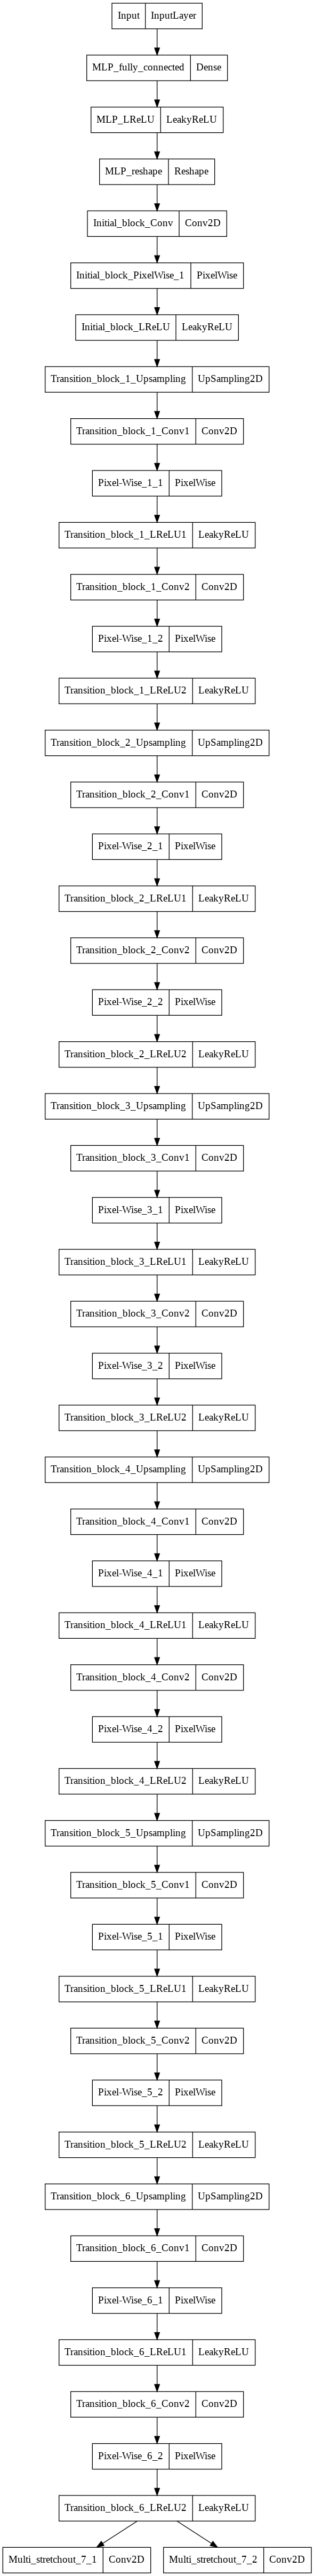

In [17]:
plot_model(generator, "gen.png")

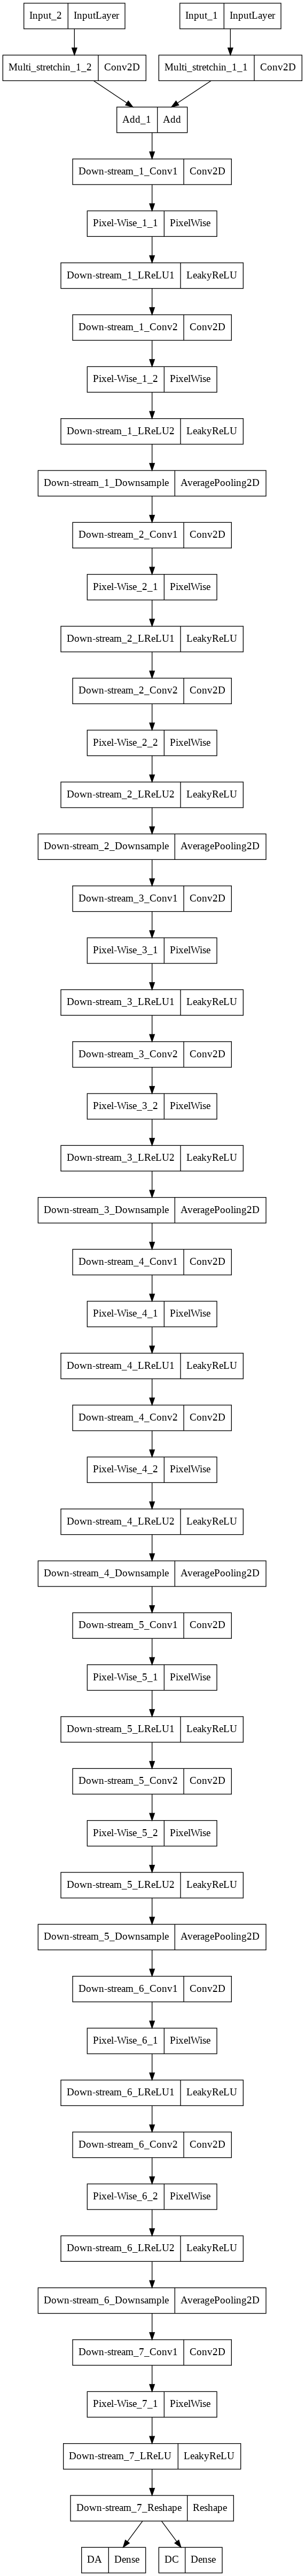

In [18]:
plot_model(discriminator, "disc.png")

## Image Synthesis : W-GAN GP 

In [ ]:
# Credits https://keras.io/examples/generative/wgan_gp/

class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        lambda_gp=10.0,
        lambda_cls=1,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.lambda_gp = lambda_gp

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        #TODO:modificare per multimodalità

        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            attributes = real_images[1]
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = np.random.uniform(-1.0, 1.0, size=latent_dim)
            g_in = np.concatenate((random_latent_vectors, attributes), axis=0)
            # random_latent_vectors = np.random.normal(shape=(batch_size, self.latent_dim), -1.0, 1.0)

            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(g_in, training=True)
                # Get the logits for the fake images
                fake_DA, fake_DC = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_DA, real_DC = self.discriminator(real_images, training=True)


                # PROVA LOSS
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                
                # Calculate the discriminator loss using the fake and real image logits and
                d_cost = self.d_loss_fn(DA_real, DA_fake, DC_real, DC_fake, self.lambda_cls, self.lambda_gp, gp)
                
                
                
                #_____________


                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_DA, fake_img=fake_DA)

                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.lambda_gp

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}



In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

def adv_loss():
  pass

def cls_real_loss():
  pass

def cls_fake_loss():
  pass

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(DA_real, DA_fake, DC_real, DC_fake, lambda_cls, lambda_gp, gp):
    
    DA_real = tf.reduce_mean(DA_real)
    DA_fake = tf.reduce_mean(DA_fake)
    DC_real = tf.reduce_mean(DC_real)
    DC_fake = tf.reduce_mean(DC_fake)

    adv = adv_loss(DA_real, DA_fake, lambda_gp, gp)
    cls_real = cls_real_loss()

    return - adv + cls_real * lambda_cls


# Define the loss functions for the generator.
def generator_loss(DA_real, DA_fake, DC_real, DC_fake, lambda_cls, gp):
    DA_real = tf.reduce_mean(DA_real)
    DA_fake = tf.reduce_mean(DA_fake)
    DC_real = tf.reduce_mean(DC_real)
    DC_fake = tf.reduce_mean(DC_fake)

    adv = adv_loss()
    cls_fake = cls_fake_loss()
    return adv + cls_fake * lambda_cls


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

## Extras

In [ ]:
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])

a_loss = self.adversarial.train_on_batch(noise, y)

combo_in = tf.cast(tf.concat([latents_in, labels_in], axis=1), dtype)


w_input= tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# add to conv
kernel_initializet=w_input

In [ ]:
# GAN

def construct_models():
  """
    Description

    Parameters
    ----------
    x (type) :  description

    Returns
    -------
    y (type) :  description
    """

  # discriminator 
  discriminator = build_discriminator(SPATIAL_DIM, C, ATT_SIZE)
  discriminator.compile(
    loss = {"DA": tf.keras.losses.BinaryCrossentropy(),
            "DC": tf.keras.losses.BinaryCrossentropy()},
    metrics = {"DA": 'accuracy', "DC": 'accuracy'},
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))

  # generator
  generator = build_generator(LATENT_DIM_GAN, ATT_SIZE, C)
  generator.compile(
    loss = {"Multi_stretchout_7_1": tf.keras.losses.BinaryCrossentropy(),
            "Multi_stretchout_7_2": tf.keras.losses.BinaryCrossentropy()},
    metrics = {"Multi_stretchout_7_1": 'accuracy', 
               "Multi_stretchout_7_2": 'accuracy'},
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))

  gan = keras.Sequential(name='DCGAN')
  gan.add(generator)
  gan.add(discriminator)
  discriminator.trainable = False 
  gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['mae'])


  return generator, discriminator, gan

G, D, GAN = construct_models()
GAN.summary()

In [ ]:
'''
  ITERATIVE MODE GENERATOR

  # input is a noise vector concatenated with an autentication_vector
  inp = Input(shape=(latent_dim + autentication_vector), name='Input')

  # MLP BLOCK
  x = Dense(4 * 4 * 512, input_dim=latent_dim + autentication_vector, name='MLP_fully_connected')(inp) 
  x = LeakyReLU(alpha=0.2, name='MLP_LReLU')(x)
  x = Reshape(target_shape=(4, 4, 512), name='MLP_reshape')(x)

  # INITIAL BLOCK 
  x = Conv2D(512, kernel_size=3, padding='same', name='Initial_block_Conv')(x)
  x = pixel_norm(x)
  x = LeakyReLU(alpha=0.2, name='Initial_block_LReLU')(x)

  # MULTIMODAL STRETCH-OUT 1
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '1', str(c + 1), False)
  
  # TRANSITION BLOCK 1
  x = add_transition_block(512, x, '1')

  # MULTIMODAL STRETCH-OUT 2
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '2', str(c + 1))

  # TRANSITION BLOCK 2
  x = add_transition_block(256, x, '2')

  # MULTIMODAL STRETCH-OUT 3
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '3', str(c + 1))

  # TRANSITION BLOCK 3
  x = add_transition_block(128, x, '3')

  # MULTIMODAL STRETCH-OUT 4
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '4', str(c + 1))

  # TRANSITION BLOCK 4
  x = add_transition_block(64, x, '4')
  
  # MULTIMODAL STRETCH-OUT 5
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '5', str(c + 1))

  # TRANSITION BLOCK 5
  x = add_transition_block(32, x, '5')
    
  # MULTIMODAL STRETCH-OUT 6
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '6', str(c + 1))

  # TRANSITION BLOCK 6
  x = add_transition_block(16, x, '6')

  # MULTIMODAL STRETCH-OUT 7
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '7', str(c + 1))



  return Model(inputs=inp, outputs=x, name='Generator_model')

  '''



'''
  ITERATIVE MODE DISCRIMINATOR

  # MULTIMODAL STRETCH-IN 1
  for c in range(modalities):
    x = add_multi_stretchin(16, inp, '1', str(c + 1))

  # DOWN-STREAM 1
  x = add_downstream(x, [16, 32], '1')
  
  # MULTIMODAL STRETCH-IN 2
  for c in range(modalities):
    x = add_multi_stretchin(32, x, '2', str(c + 1))

  # DOWN-STREAM 2
  x = add_downstream(x, [32, 64], '2')

  # MULTIMODAL STRETCH-IN 3
  for c in range(modalities):
    x = add_multi_stretchin(64, x, '3', str(c + 1))

  # DOWN-STREAM 3
  x = add_downstream(x, [64, 128], '3')
  
  # MULTIMODAL STRETCH-IN 4
  for c in range(modalities):
    x = add_multi_stretchin(128, x, '4', str(c + 1))

  # DOWN-STREAM 4
  x = add_downstream(x, [128, 256], '4')
  
  # MULTIMODAL STRETCH-IN 5
  for c in range(modalities):
    x = add_multi_stretchin(256, x, '5', str(c + 1))

  # DOWN-STREAM 5
  x = add_downstream(x, [256, 512], '5')
  
  # MULTIMODAL STRETCH-IN 6
  for c in range(modalities):
    x = add_multi_stretchin(512, x, '6', str(c + 1))

  # DOWN-STREAM 6
  x = add_downstream(x, [512, 512], '6')
  
  # MULTIMODAL STRETCH-IN 7
  for c in range(modalities):
    x = add_multi_stretchin(512, x, '7', str(c + 1))

  # DOWN-STREAM 7
  x = Conv2D(512, kernel_size=3, padding='same', name='Down-stream_7_Conv1')(x)
  x = pixel_norm(x)
  x = LeakyReLU(alpha=0.2, name='Down-stream_7_LReLU')(x)
  x = Reshape((8192,), name='Down-stream_7_Reshape')(x)

  # FULLY-CONNECTED 1
  DA = Dense(16, name='Fully_Connected_1')(x)

  # FULLY-CONNECTED 2
  DC = Dense(attribute_size + 2, name='Fully_Connected_2_DC')(x)

  return Model(inputs=inp, outputs=DA, name='Discriminator_model_1'), Model(inputs=inp, outputs=DC, name='Discriminator_model_2')'''



'''
    # Not used for now 
  def add_block_G(block_num: str, x, ms_output, linear: bool, tb_outpu): 
    """
    Add a module to the network. Deprecated
    """
    # MULTIMODAL STRETCH-OUT EMBEDDING 
    c1 = add_multi_stretchout(ms_output, x, block_num, '1', linear)
    c2 = add_multi_stretchout(ms_output, x, block_num, '2', linear)
    x = add([c1, c2])

    
    # MULTIMODAL STRETCH-OUT 
    for c in range(modalities):
      x = add_multi_stretchout(ms_output, x, block_num, str(c + 1), linear)
    

    # TRANSITION BLOCK
    x = add_transition_block(tb_outpu, x, block_num)

    return x'''





  def pixel_norm(x, epsilon=1e-8):

    return x * tf.math.rsqrt(tf.reduce_mean(tf.square(x), axis=1, keepdims=True) + epsilon)


  def add_block_D(block_num: str, x, i, ds_output): 
    """
    Description

    Parameters
    ----------
    x (type) :  description

    Returns
    -------
    y (type) :  description
    """

    # MULTIMODAL STRETCH-IN
    for c in range(modalities):
      x = add_multi_stretchin(16*2**i, x, block_num, str(c + 1))

    # DOWN-STREM BLOCK
    x = add_downstream(x, ds_output, block_num)
    return x


## Recognition on new dataset

In [ ]:
# clone fairface project

import os

%cd /content/
!git clone https://github.com/dchen236/FairFace
%cd FairFace/


/content
Cloning into 'FairFace'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 220 (delta 4), reused 0 (delta 0), pack-reused 211
Receiving objects: 100% (220/220), 14.23 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (111/111), done.
